In [1]:
import numpy as np
import trimesh
import matplotlib.pyplot as plt
import copy

In [2]:
def boundary(mesh):
    
    """ A function to find the boundary edges and vertices of a mesh. 
        Inputs:
        mesh: a trimesh mesh. 
        Outputs: 
        boundary_vertices: a list of the indices of vertices on the boundary. 
        next_vertex: a dictionary to find the next vertex on the boundary. 
    """

    next_vertex = {}
    boundary_vertices = []

    edges = mesh.edges
    vertex_faces = mesh.vertex_faces
    
    for i in range(len(edges)):

        edge = edges[i]
        v1, v2 = edge
        faces = [j for j in vertex_faces[v1] if j != -1 and j in vertex_faces[v2]]
        
        # Boundary edges are edges that are only in one face
        if len(faces) == 1:

            next_vertex[v1] = v2
            boundary_vertices = boundary_vertices + [v1, v2]
    
    # Remove any duplicates
    boundary_vertices = np.unique(np.array(boundary_vertices))
    
    return boundary_vertices, next_vertex

In [3]:
def get_quartile_length(mesh_vertices, next_vertex_dict):
    """ A function to find 1/4 of the length of all distances around the boundary of a mesh. 
        Inputs:
        mesh_vertices: array of all vertices of a trimesh.
        next_vertex_dict: a dictionary to find the next vertex on the boundary.  

        Outputs:
        quartile_length: 1/4 of the length of total distance around boundary.
        distances: a dictionary to find the distance of a vertex from its previous vertex.
    """
        
    # get first vertex index on boundary
    current_vertex_idx = list(next_vertex_dict.keys())[0]

    # keep track of distances
    distances = {}
    total_dist = 0.0
    for i in range(len(next_vertex_dict)):
        # get currrent vertex values
        current_vertex = mesh_vertices[current_vertex_idx]

        # get next vertex index
        next_vertex_idx = next_vertex_dict[current_vertex_idx]
        # get next vertex value
        next_vertex = mesh_vertices[next_vertex_dict[current_vertex_idx]]

        dist = np.linalg.norm(next_vertex - current_vertex)
        distances[next_vertex_idx] = dist
        total_dist += dist

        # reset current vertex idk
        current_vertex_idx = next_vertex_idx

    quartile_length = total_dist/4


    return quartile_length, distances

In [53]:
def square_boundary(mesh):
    """ A function to map the boundary of a mesh to a square. 
        Inputs:
        mesh: a trimesh mesh. 
        quartile_dist: float value for the 1/4 of the total distance around boundary
        dist_dict: dictionary that maps vertex to a distance from its previous vertex
        
        Outputs: 
        new_boundary_values: an array of boundary values (2 dimensional) on the circle. 
    """

    mesh_vertices = mesh.vertices
    output = np.zeros((len(mesh_vertices), 2))

    range_x = (np.max(mesh_vertices[:, 0]) - np.min(mesh_vertices[:, 0]))/2
    range_y = (np.max(mesh_vertices[:, 1]) - np.min(mesh_vertices[:, 1]))/2
    range_z = (np.max(mesh_vertices[:, 2]) - np.min(mesh_vertices[:, 2]))/2

    # keep the sqaure roughly the same size as the mesh by choosing half of maximum range as unit
    unit = np.max([range_x, range_y, range_z])

    unit_square = np.array([[0.0,0.0], 
                        [unit,0.0], 
                        [unit,unit],  
                        [0.0,unit]])
    
    boundary_vertices, next_vertex_dict = boundary(mesh)
    quartile_dist, dist_dict = get_quartile_length(mesh_vertices, next_vertex_dict)

    # keep track of total_dist for each edge of square 
    total_dist = 0.0
    # get first vertex index on boundary
    starting_vertex_idx = list(next_vertex_dict.keys())[0]
    current_vertex_idx = starting_vertex_idx
    next_vertex_idx = next_vertex_dict[current_vertex_idx]
    # track vertices to remap (include first two vertices in map)
    vertices_to_map = [current_vertex_idx, next_vertex_idx]
    # include their respective distances to current_vertex
    dist = dist_dict[next_vertex_idx]
    dist_list = [0.0, dist]
    for i in range(4): #loop for each side of square
        # track corners
        A = unit_square[i % len(unit_square)]
        B = unit_square[(i + 1) % len(unit_square)]

        # sum up distances on edge until we reach 1/4 of total distace
        # if final edge of square then sum up all remaining distances (as division will never be perfect)
        while(total_dist + dist < quartile_dist or i == 3):
            next_vertex_idx = next_vertex_dict[current_vertex_idx]

            total_dist += dist
            dist_list.append(total_dist)
            vertices_to_map.append(next_vertex_idx)
            current_vertex_idx = next_vertex_idx
            dist = dist_dict[current_vertex_idx]
            # break once back at starting vertex 
            if(current_vertex_idx == starting_vertex_idx):
                break
        # calculate new positions in two dimensions
        output[vertices_to_map] = [d/total_dist * (B - A) + A for d in dist_list]
        
        # update values for next edge of sqaure
        total_dist = dist
        dist_list = [0.0, dist]
        next_vertex_idx = next_vertex_dict[current_vertex_idx]
        vertices_to_map = [current_vertex_idx, next_vertex_idx]
        current_vertex_idx = next_vertex_idx

    new_boundary_values = output[boundary_vertices]
    return new_boundary_values

9.34141925


'# https://github.com/mikedh/trimesh\nv -6.52889010 5.49005320 -6.22479870\nv 0.35277206 0.00000000 -12.00000000\nv -5.81779670 -5.07507990 -8.55370240\nv 0.00000000 0.31249404 -12.00000000\nv 6.86571880 4.88439180 -7.15710880\nv 6.53557400 5.43919660 -6.24136880\nv 9.34141925 0.18289083 -12.00000000\nv 9.34141925 0.89657904 -12.00000000\nv 5.82194710 -5.07033540 -8.55861280\nv -3.76459310 -6.91110420 -5.99737550\nv 2.15191703 0.00000000 -12.00000000\nv 1.56221720 0.00000000 -12.00000000\nv -4.36145310 -6.44226360 -6.47173600\nv 7.82463973 0.00000000 -12.00000000\nv 3.70482420 -6.97741700 -5.99599310\nv 7.20774179 0.00000000 -12.00000000\nv 8.35026552 0.00000000 -12.00000000\nv 4.40413810 -6.37939070 -6.43920900\nv -1.98354100 -3.59482910 -3.04394670\nv 2.07534030 -3.60313990 -3.13412090\nv 2.01611520 -3.59473420 -3.07795330\nv 2.01764300 -3.59855460 -3.08578490\nv -5.31644440 3.23881340 -4.60460660\nv -5.13686370 3.22333910 -4.50870130\nv -5.02795080 3.57652520 -4.08234980\nv -5.27033

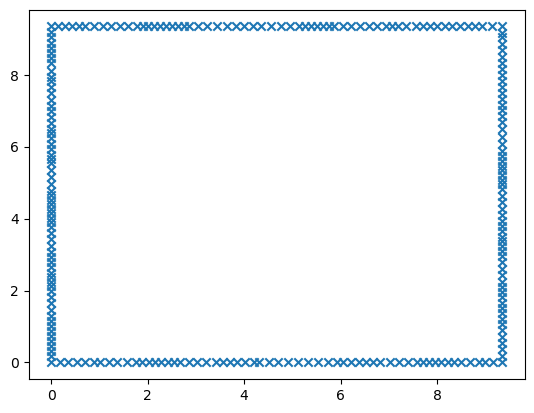

In [52]:
lilium = trimesh.load("./meshes/face.obj")
vertices = lilium.vertices
new_vertices = np.copy(vertices)
boundary_vertices, next_vertex_dict = boundary(lilium)
lillium_vertices = lilium.vertices

new_boundary_values = square_boundary(lilium)

x = new_boundary_values[:, 0]
y = new_boundary_values[:, 1]
plt.scatter(x, y, marker = 'x')
lilium.vertices[boundary_vertices] = np.hstack((new_boundary_values, -12*np.ones((len(x), 1))))
lilium.export("SquareExperiment.obj")

In [44]:
len(boundary_vertices)

186